# HiddenLayer Train Demo - Keras

In this notebook, we train an MNIST classifier using transfer learning with:
- a pre-trained VGG16 convnet for feature extraction,
- our own 10-output sotfmax layer with cross-entropy loss (log loss) as our classifier.

We use:
- `Keras` for model training and use dropout and early stopping to prevent overfitting
- `sklearn` to generate a confusion matrix on the validation split
- `hiddenlayer` to validate our "before/after" convnet and check our progress (visualizing the confusion matrix as we go)

This model only takes **~3 minutes to train** to reach 97% prediction accuracy on the validation split.

In [1]:
from __future__ import absolute_import, division, print_function
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import numpy as np
import itertools
from matplotlib import pyplot as plt

import hiddenlayer as hl
import hiddenlayer.transforms as ht

## Hyperparams and constants

In [2]:
# Mini-batch size (backprop will take a step of gradient descent every batch_size)
batch_size = 128  

# Number of epochs to train for (early stopping may shorten this schedule)
num_epochs = 20

# Adam optimizer base learning rate
base_lr = 1e-3

# The VGG16 net was trained on 244x244 images but since we're not using the fully-connect
# layers, we can use whatever input size we want to generate the convolutional features.
# That being said, 28x28 is too small an input for VGG16 because the last feature map of 
# the convent has a size that is 1/16th the size of the input image. If you try 28x28x3 as
# an input size, you will get a `ValueError: Input size must be at least 48x48`
# -> we will scale our samples to the convnet's minimum input size
input_shape = (48, 48, 3)

## Prepare the train/val dataset splits

In [3]:
# Load the data using the default train/validation split
# We would, indeed, use train_test_split if we needed a different split than the default one
(x_train, y_train), (x_val, y_val) = mnist.load_data()

# Extract image size
assert(len(x_train.shape) == 3)
_, x_height, x_width = x_train.shape

# Extract number of classes
assert(len(y_train.shape) == 1)
y_classes = len(np.unique(y_train))

In [4]:
# Sanity check
print(f"{x_train.shape[0]} train samples with size {x_train.shape[1:]} and range [{np.min(x_train)}, {np.max(x_train)}]")
print(f"{x_val.shape[0]} val samples with size {x_val.shape[1:]} and range [{np.min(x_val)}, {np.max(x_val)}]")
print(f"{y_train.shape[0]} train labels with range [{np.min(y_train)}, {np.max(y_train)}]")
print(f"{y_val.shape[0]} val labels with range [{np.min(y_val)}, {np.max(y_val)}]")
print(f"Sample size: {x_height}x{x_width}")
print(f"Sample size: {y_classes}")

60000 train samples with size (28, 28) and range [0, 255]
10000 val samples with size (28, 28) and range [0, 255]
60000 train labels with range [0, 9]
10000 val labels with range [0, 9]
Sample size: 28x28
Sample size: 10


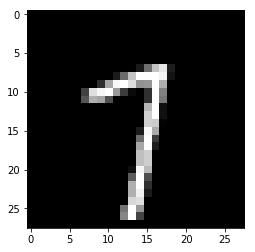

In [5]:
# Visual check
plt.imshow(x_train[42], cmap='gray')
plt.show()

## Adapt the train/val splits to the convnet input/label format requirements

In [6]:
# Make sure the backend used by Keras uses a channels_last format
assert(K.image_data_format() == 'channels_last')

In [7]:
# The VGG16 backbone was trained on RGB data in the [0.,1.] range
# -> convert data to float and perform min-max normalization
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255

# The VGG16 backbone was trained on color RGB data (imagenet)
# -> resize the samples from (#, 28, 28) to (#, input_shape[0], input_shape[1])
if input_shape[0:2] != (x_height, x_width):
    x_train = [cv2.resize(x, input_shape[0:2]) for x in x_train]
    x_val = [cv2.resize(x, input_shape[0:2]) for x in x_val]

# -> reshape the samples from (#, H, W) to (#, H, W, 3)
#    by copying the "gray" MNIST images identically across the 3 RGB channels
x_train = np.stack((x_train, x_train, x_train), axis=-1)
x_val = np.stack((x_val, x_val, x_val), axis=-1)

In [8]:
# One-hot encode labels for use by softmax with multiclass cross-entropy loss
y_train = to_categorical(y_train, y_classes)
y_val = to_categorical(y_val, y_classes)

In [9]:
# Sanity check
print(f"{x_train.shape[0]} train samples with size {x_train.shape[1:]} and range [{np.min(x_train)}, {np.max(x_train)}]")
print(f"{x_val.shape[0]} val samples with size {x_val.shape[1:]} and range [{np.min(x_val)}, {np.max(x_val)}]")
print(f"{y_train.shape[0]} train labels with shape {y_train.shape[1:]}")
print(f"{y_val.shape[0]} val labels with shape {y_val.shape[1:]}")

60000 train samples with size (48, 48, 3) and range [0.0, 1.0]
10000 val samples with size (48, 48, 3) and range [0.0, 1.0]
60000 train labels with shape (10,)
10000 val labels with shape (10,)


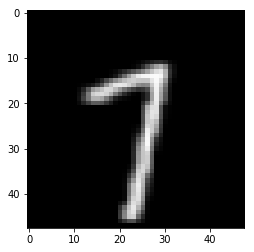

In [10]:
# Visual check
plt.imshow(x_train[42])
plt.show()

## Put the model (convnet base + classifier) together

In [11]:
# Set the learning phase to training
K.set_learning_phase(1)

In [12]:
# Build the VGG16 model as a feature extractor
convnet = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

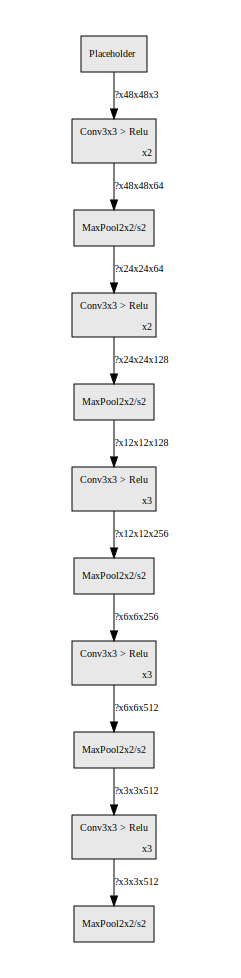

In [13]:
# Visual check of the "before" model architecture using HiddenLayer
hl_graph = hl.build_graph(K.get_session().graph)
hl_graph

In [14]:
# Build our own classifier on top of the VGG16 feature extractor using
# two fully-connected layers with dropout and a final softmax layer
classifier = Flatten(input_shape=convnet.output_shape[1:])(convnet.output)
classifier = Dense(512, activation='relu')(classifier) # fc1
classifier = Dropout(0.5)(classifier)
classifier = Dense(512, activation='relu')(classifier) # fc2
classifier = Dropout(0.5)(classifier)
classifier = Dense(10, activation='softmax')(classifier) # softmax classifier for classes 0..9

In [15]:
# Finally, put the model together
model = Model(inputs=convnet.input, outputs=classifier)

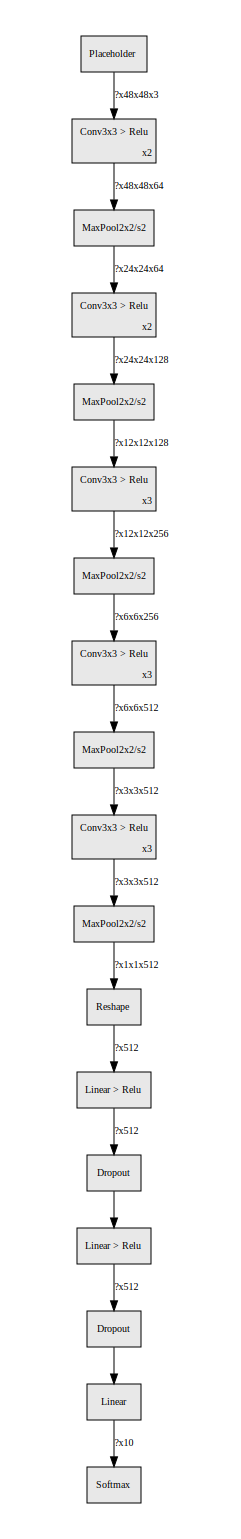

In [16]:
# Visual check of the "after" model architecture using HiddenLayer
hl_graph = hl.build_graph(K.get_session().graph)
hl_graph

## Create a custom callback to compute and visualize a confusion matrix

In [17]:
class ConfusionMatrixCanvas(hl.Canvas):
    """Extending HiddenLayer's Canvas to plot a confusion matrix."""

    def __init__(self, classes, normalize=False, title='Confusion matrix'):
        """Normalization can be applied by setting 'normalize=True'.
        """
        super().__init__()
        self.classes = range(0, classes)
        self.normalize = normalize
        self.title = title
    
    def draw_confusion_matrix(self, metric):
        """This function plots the confusion matrix.
        Ref:
            https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        # Normalize confusion matrix, if requested, and set numbers display format
        cm = metric.data[-1]
        if self.normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fmt = '.2f'
        else:
            fmt = 'd'

        # Build the plot
        self.ax.axis('equal')  
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(self.title)
        # plt.colorbar()
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
class ConfusionMatrixHistory(Callback):
    """Extending Keras' Callback to compute a confusion matrix."""
    
    def __init__(self, x_val, y_val, train_size, y_classes):
        # Keep a reference to the validation data
        self.x_val = x_val
        self.y_val = [np.argmax(y) for y in y_val]
        self.train_size = train_size
        
        # Use a HiddenLayer History object to store metrics
        self.history = hl.History()

        # Use our custom HiddenLayer Canvas object to draw the metrics
        self.canvas = ConfusionMatrixCanvas(y_classes)        
        
    def on_train_begin(self, logs={}):
        self.acc, self.val_acc, self.val_cm = [], [], []
        self.epoch = 0
        print('Train on {} samples, validate on {} samples...'.format(self.train_size, self.x_val.shape[0]))
              
    def on_epoch_end(self, batch, logs={}):
        # Generate predictions for validation data
        y_val_hat = self.model.predict(self.x_val)
        y_val_hat = [np.argmax(y) for y in y_val_hat]
              
        # Compute the accuracy and generate a confusion matrix using the validation data
        val_acc = accuracy_score(self.y_val, y_val_hat)
        cm = confusion_matrix(self.y_val, y_val_hat)
              
        # Store the metrics in the history object
        self.history.log(self.epoch, acc=logs.get('acc'), val_acc=val_acc, cm=cm)
              
        # Plot the metrics
        with self.canvas:
            # self.canvas.draw_cm([self.history["acc"], self.history["cm"]])
            self.canvas.draw_confusion_matrix(self.history["cm"])
            self.canvas.draw_plot([self.history["acc"], self.history["val_acc"]])
              
        # Onto the next epoch...
        self.epoch += 1

callbacks = [ConfusionMatrixHistory(x_val, y_val, x_train.shape[0], y_classes)]

## Compile the model so we'll only train the classifier head

In [18]:
# Since we only want to use the convnet as a feature extractor, 
# freeze the convnet layers and only train the classifier head
for layer in convnet.layers:
    layer.trainable = False

In [19]:
# Compile the model using the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(base_lr), metrics=['acc'])

## Train the model

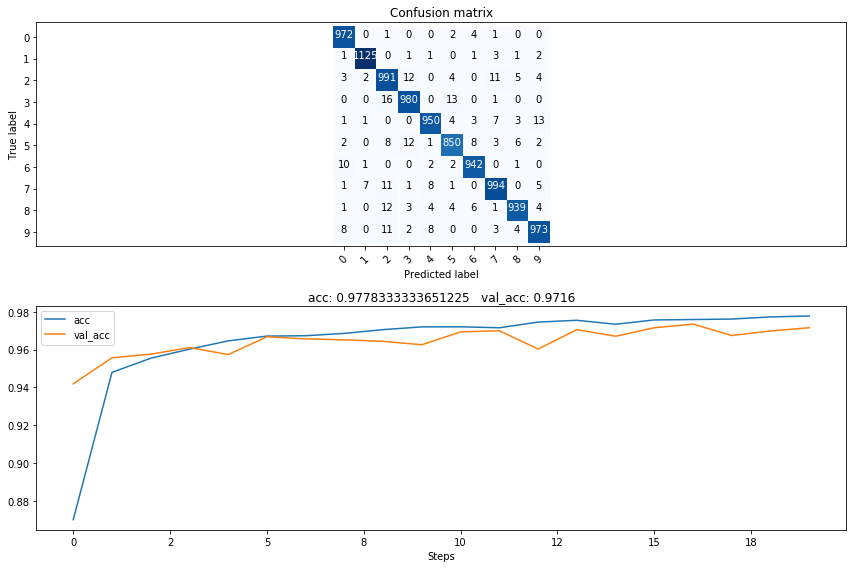

In [20]:
# Train the the model
history = model.fit(x_train, y_train, batch_size, num_epochs, verbose=0, callbacks=callbacks)